In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os

In [292]:
EVAL_DIRECTORY = "/Users/vineelbhat/Documents/CS199/RubricEval/data/evaluations"
REPORT_FILENAME = "report_evaluations_evaluations.json"

# of models: 32



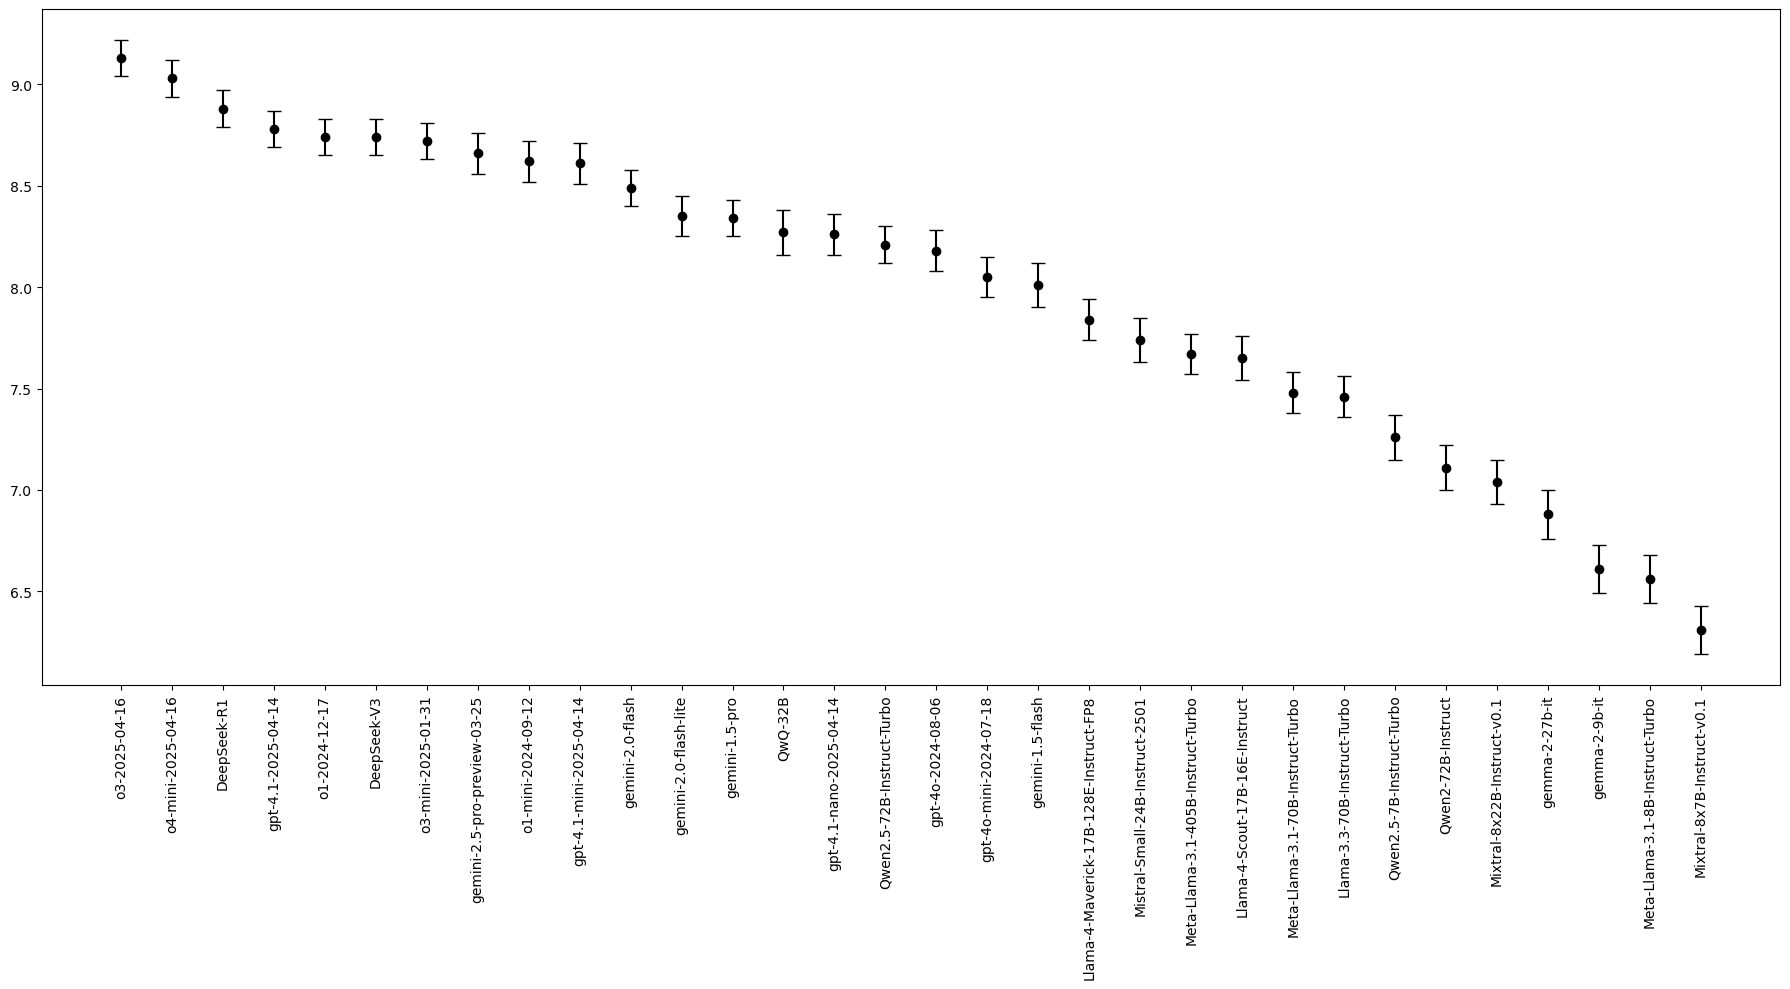

In [297]:
model_list = []
score_list = []
error_list = []

for dir in os.listdir(EVAL_DIRECTORY):
    filename = f"{EVAL_DIRECTORY}/{dir}/{REPORT_FILENAME}"
    if os.path.exists(filename):
        with open(filename) as f:   
            report = json.load(f)
            model_list.append(report["model"])
            score_list.append(round(float(report["weighted_score_mean"]), 2))
            error_list.append(round(float(report["weighted_score_sem"]), 2))

print(f"# of models: {len(model_list)}\n")

plotDf = pd.DataFrame()
plotDf["model"] = model_list
plotDf["score"] = score_list
plotDf["error"] = error_list
plotDf = plotDf.sort_values(by = ["score"], ascending = False).reset_index(drop = True)

plt.figure(figsize = (18, 10))
plt.scatter(x = plotDf["model"], y = plotDf["score"], color = "black")
plt.errorbar(x = plotDf["model"], y = plotDf["score"], yerr = plotDf["error"], fmt = "none", ecolor = "black", capsize = 5)
ax.set_ylim(ymin = 1)
ax.set_ylim(ymax = 10)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [298]:
from scipy.stats import spearmanr, pearsonr

Arena: full (25 models)
Spearman: correlation = 0.922, p-value = 5.816e-11
Pearson: correlation = 0.899, p-value = 1.027e-09



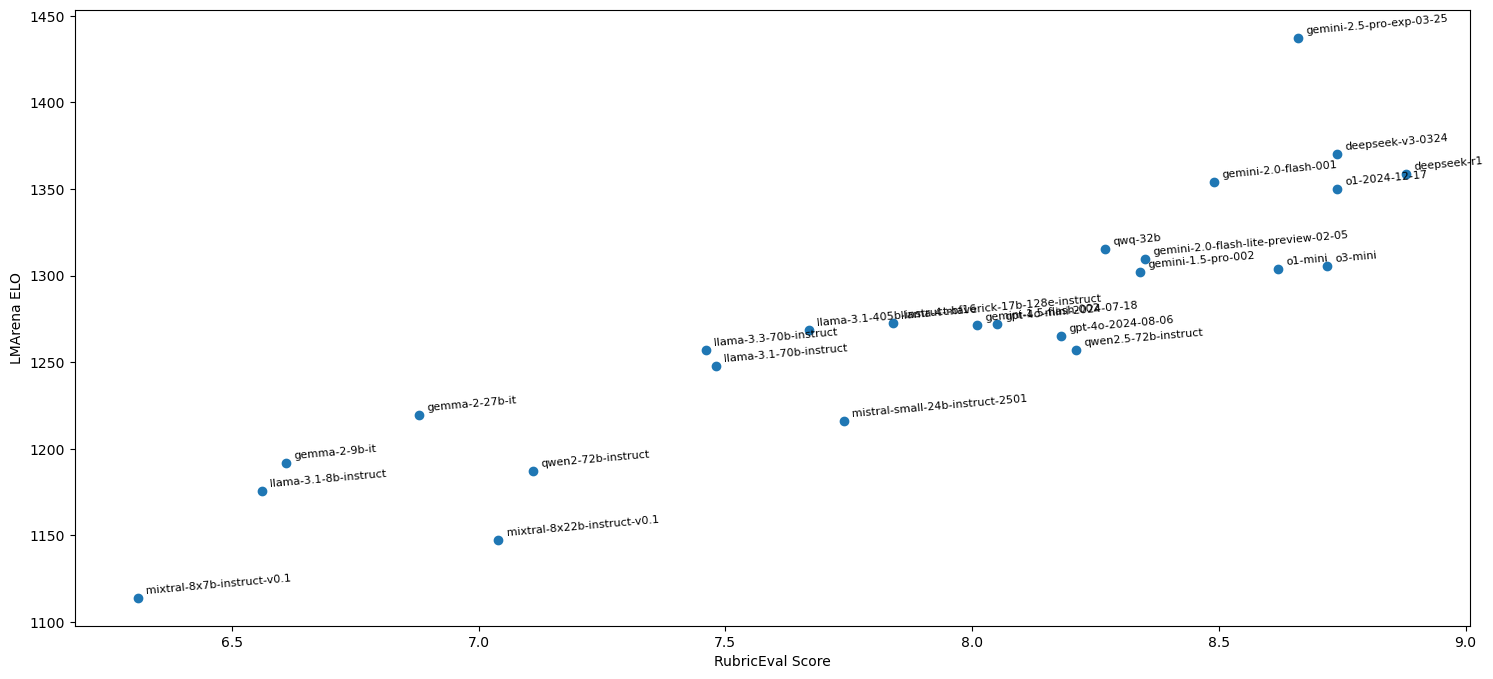

Arena: full_style_control (25 models)
Spearman: correlation = 0.923, p-value = 5.209e-11
Pearson: correlation = 0.884, p-value = 4.532e-09



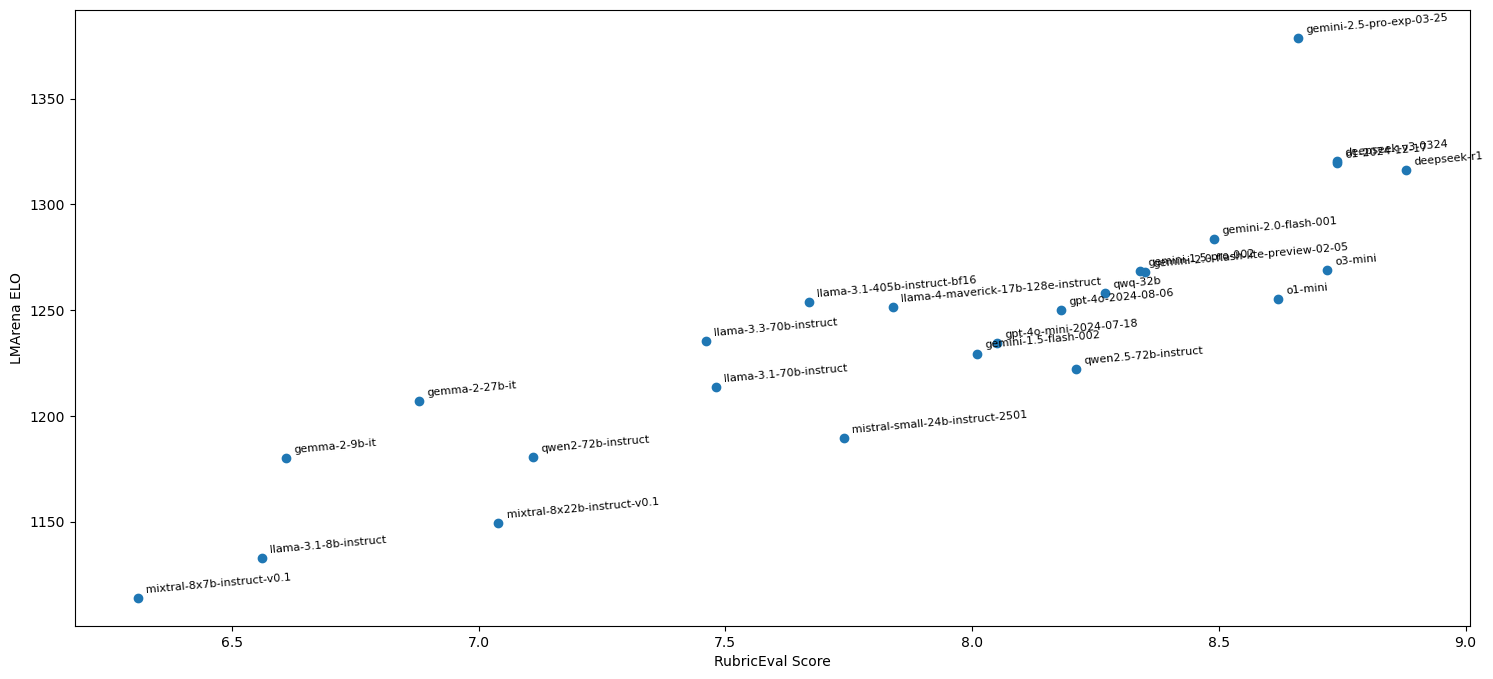

Arena: hard_6 (25 models)
Spearman: correlation = 0.946, p-value = 9.784e-13
Pearson: correlation = 0.925, p-value = 3.711e-11



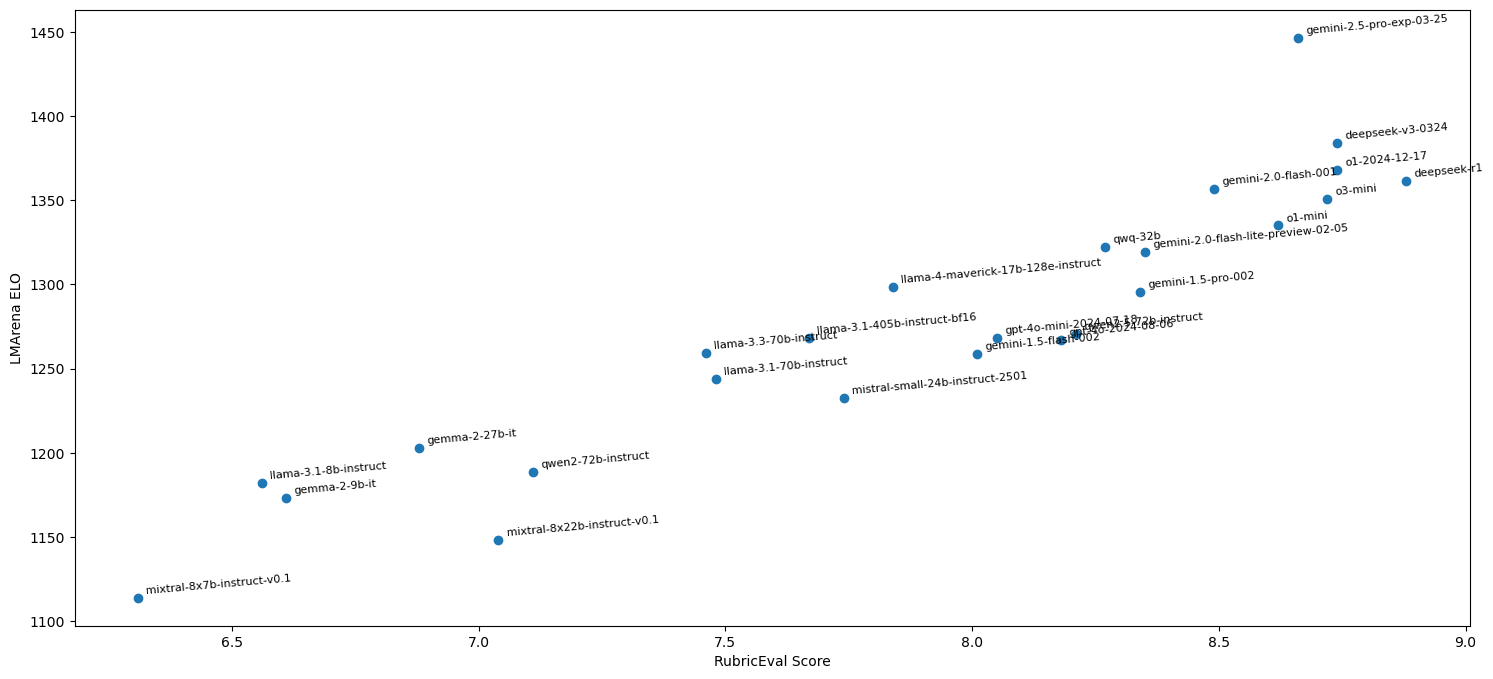

Arena: hard_english_6 (25 models)
Spearman: correlation = 0.943, p-value = 1.689e-12
Pearson: correlation = 0.918, p-value = 1.089e-10



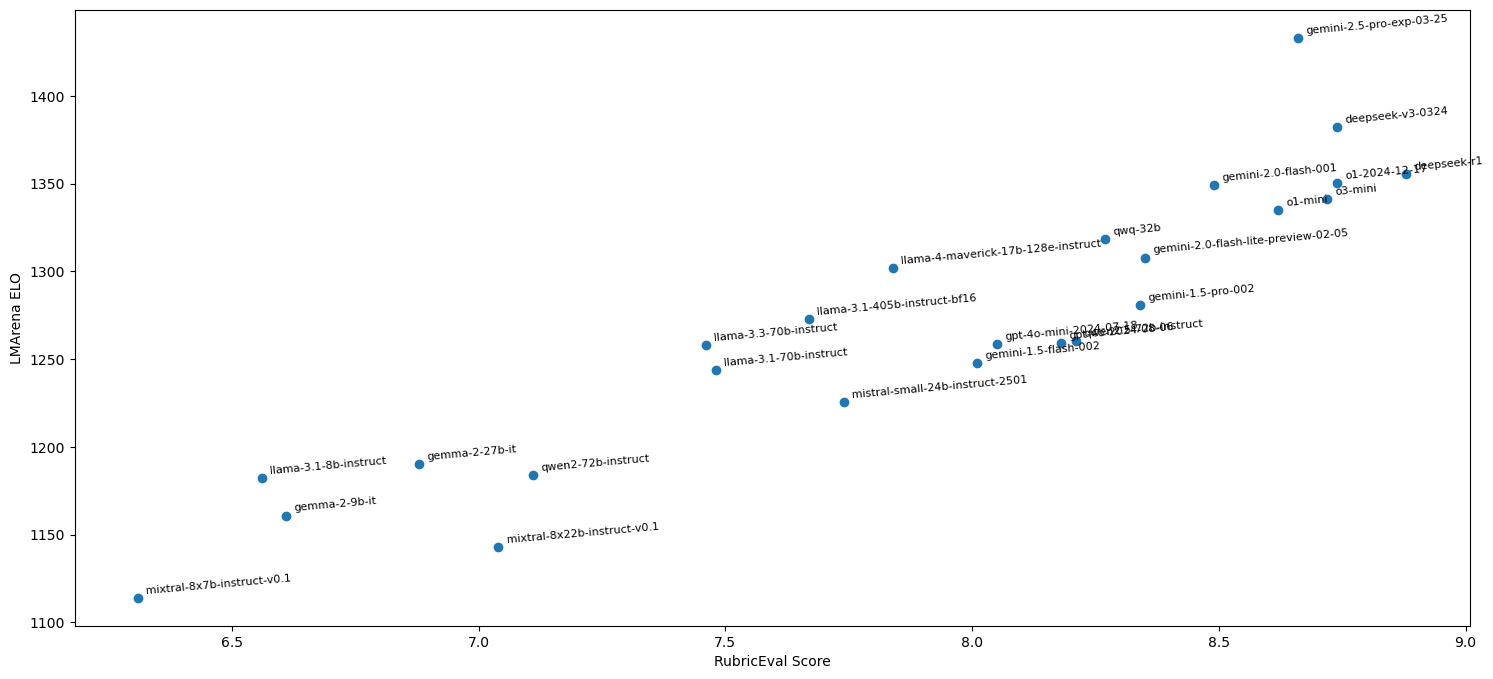

In [301]:
# Pull data from 04/09/25 LMArena update
lmaElos = {}
with open("/Users/vineelbhat/Downloads/elo_results_20250409.pkl", "rb") as f:
    lmaData = pickle.load(f)["text"]
    for arena in lmaData.keys():
        lmaDf = lmaData[arena]["elo_rating_final"].reset_index()
        lmaDf.columns = ["model", "elo"]
        lmaElos[arena] = {model.lower(): elo for model, elo in zip(list(lmaDf["model"]), list(lmaDf["elo"]))}

'''
Arena categories:
['french', 'full_style_control', 'full', 'creative_writing',
'creative_writing_style_control', 'coding', 'coding_style_control',
'if', 'if_style_control', 'math', 'math_style_control',
'hard_6_style_control', 'hard_6', 'hard_english_6', 'english',
'chinese', 'multiturn', 'multiturn_style_control',
'long_user', 'long_user_style_control', 'german', 'spanish',
'russian', 'japanese', 'korean', 'no_tie', 'no_short', 'no_refusal']
'''

modelScores = {model.lower(): score for model, score in zip(list(plotDf["model"]), list(plotDf["score"]))}

# Rename some models to match LMArena
modelScores["deepseek-v3-0324"] = modelScores.pop("deepseek-v3")
modelScores["o3-mini"] = modelScores.pop("o3-mini-2025-01-31")
modelScores["o1-mini"] = modelScores.pop("o1-mini-2024-09-12")
modelScores["llama-4-maverick-17b-128e-instruct"] = modelScores.pop("llama-4-maverick-17b-128e-instruct-fp8")
modelScores["llama-3.3-70b-instruct"] = modelScores.pop("llama-3.3-70b-instruct-turbo")
modelScores["llama-3.1-70b-instruct"] = modelScores.pop("meta-llama-3.1-70b-instruct-turbo")
modelScores["llama-3.1-405b-instruct-bf16"] = modelScores.pop("meta-llama-3.1-405b-instruct-turbo")
modelScores["llama-3.1-8b-instruct"] = modelScores.pop("meta-llama-3.1-8b-instruct-turbo")
modelScores["qwen2.5-72b-instruct"] = modelScores.pop("qwen2.5-72b-instruct-turbo")
modelScores["qwen2.5-7b-instruct"] = modelScores.pop("qwen2.5-7b-instruct-turbo")
modelScores["gemini-2.0-flash-001"] = modelScores.pop("gemini-2.0-flash")
modelScores["gemini-2.0-flash-lite-preview-02-05"] = modelScores.pop("gemini-2.0-flash-lite")
modelScores["gemini-1.5-pro-002"] = modelScores.pop("gemini-1.5-pro")
modelScores["gemini-1.5-flash-002"] = modelScores.pop("gemini-1.5-flash")
modelScores["gemini-2.5-pro-exp-03-25"] = modelScores.pop("gemini-2.5-pro-preview-03-25")

for arena in ["full", "full_style_control", "hard_6", "hard_english_6"]:
    modelElos = lmaElos[arena]
    models = [model for model in modelScores if model in modelElos]
    scores, elos = [modelScores[model] for model in models], [modelElos[model] for model in models]

    spearman_corr, spearman_pval = spearmanr(scores, elos)
    pearson_corr, pearson_pval = pearsonr(scores, elos)
    
    print(f"Arena: {arena} ({len(models)} models)")
    print(f"Spearman: correlation = {spearman_corr:.3f}, p-value = {spearman_pval:.3e}")
    print(f"Pearson: correlation = {pearson_corr:.3f}, p-value = {pearson_pval:.3e}")
    print()

    plt.figure(figsize = (18, 8))
    plt.scatter(scores, elos)
    plt.xlabel("RubricEval Score")
    plt.ylabel("LMArena ELO")

    for i, model in enumerate(models):
        plt.text(scores[i] + 0.015, elos[i] + 2.5, model, fontsize = 8, rotation = 5)
    
    plt.show()